In [2]:
import numpy as np
import pandas as pd
from arch import arch_model
from hurst import compute_Hc
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import numpy as np
import MetaTrader5 as mt5
import matplotlib.pyplot  as plt

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from sklearn.linear_model import LinearRegression

from scipy.signal import find_peaks
from scipy.interpolate import interp1d


import hurst as hs


In [15]:
def obter_dados(symbol, n_barras=10000):

    # Inicializa o MT5
    if not mt5.initialize():
        print("Falha ao inicializar MT5")
        mt5.shutdown()
    else:
        print("MT5 inicializado com sucesso")

    rates = mt5.copy_rates_from_pos(symbol, mt5.TIMEFRAME_M15, 0, n_barras)
    df = pd.DataFrame(rates)
    df['Date'] = pd.to_datetime(df['time'], unit='s')
    df.rename(columns={'open': 'Open', 'high': 'High', 'low': 'Low', 'close': 'Close'}, inplace=True)
    df = df[['Date','Open','High','Low','Close']]
    return df

def calculate_garch_bands(df):
    """
    Calcula bandas GARCH(1,1) SEM lookahead:
    - Retornos logarítmicos
    - Volatilidade GARCH até o final do dia anterior
    - Bandas diárias fixadas em 2 e 4 desvios
    
    Parâmetros:
    df : pd.DataFrame
        DataFrame com colunas 'Date' e 'Close'.
        
    Retorna:
    pd.DataFrame
        DataFrame com colunas adicionais:
        - Log_Returns
        - reference_price
        - daily_vol_garch
        - upper_garch_1d_2d, upper_garch_1d_4d
        - lower_garch_1d_2d, lower_garch_1d_4d
        - garch_mid_d
    """
    
    df = df.copy()
    
    # Converter data e calcular retornos logarítmicos
    df['time'] = pd.to_datetime(df['time'])
    df['Log_Returns'] = np.log(df['close'] / df['close'].shift(1))
    df.dropna(inplace=True)
    df['Day'] = df['time'].dt.to_period('D')
    
    # Lista de dias
    days = sorted(df['Day'].unique())
    
    all_bands = []
    
    for i, day in enumerate(days):
        if i == 0:
            continue  # Primeiro dia não tem referência anterior
        
        # Subconjunto até o final do dia anterior
        subset = df[df['Day'] <= days[i-1]]
        
        # Ajusta GARCH até o dia anterior
        garch_model = arch_model(subset['Log_Returns'] * 100, vol='Garch', p=1, q=1, dist='Normal')
        garch_result = garch_model.fit(disp="off")
        
        # Volatilidade condicional do último candle do dia anterior
        vol_last = garch_result.conditional_volatility.iloc[-1] / 100
        
        # Preço de fechamento do dia anterior
        ref_price = subset[subset['Day'] == days[i-1]]['close'].iloc[-1]
        
        # Cria bandas para todos os candles do dia atual
        day_data = df[df['Day'] == day].copy()
        day_data['reference_price_d'] = ref_price
        day_data['daily_vol_garch'] = vol_last
        
        for d in [2, 4]:
            day_data[f'upper_garch_1d_{d}d'] = (1 + d * vol_last) * ref_price
            day_data[f'lower_garch_1d_{d}d'] = (1 - d * vol_last) * ref_price
        
        day_data['garch_mid_d'] = (day_data['upper_garch_1d_2d'] + day_data['lower_garch_1d_2d']) / 2
        
        all_bands.append(day_data)
    
    # Concatenar resultados
    result = pd.concat(all_bands)
   # result.set_index("time", inplace=True)
    
    return result

def calculate_garch_bands_weekly(df):
    """
    Calcula bandas GARCH(1,1) SEM lookahead:
    - Retornos logarítmicos
    - Volatilidade GARCH até o final da semana anterior
    - Bandas semanais fixadas em 2 e 4 desvios
    
    Parâmetros:
    df : pd.DataFrame
        DataFrame com colunas 'Date' e 'Close'.
        
    Retorna:
    pd.DataFrame
        DataFrame com colunas adicionais:
        - Log_Returns
        - reference_price
        - weekly_vol_garch
        - upper_garch_1w_2d, upper_garch_1w_4d
        - lower_garch_1w_2d, lower_garch_1w_4d
        - garch_mid_w
    """
    df = df.copy()
    
    # Converter datas e calcular retornos
    df['time'] = pd.to_datetime(df['time'])
    df['Log_Returns'] = np.log(df['close'] / df['close'].shift(1))
    df.dropna(inplace=True)
    df['Week'] = df['time'].dt.to_period('W')  # Agrupamento semanal
    
    # Lista de semanas
    weeks = sorted(df['Week'].unique())
    
    all_bands = []
    
    for i, week in enumerate(weeks):
        if i == 0:
            continue  # Primeira semana não tem referência anterior
        
        # Subconjunto até o fim da semana anterior
        subset = df[df['Week'] <= weeks[i-1]]
        
        # Ajusta GARCH até semana anterior
        garch_model = arch_model(subset['Log_Returns'] * 100, vol='Garch', p=1, q=1, dist='Normal')
        garch_result = garch_model.fit(disp="off")
        
        # Volatilidade condicional do último candle da semana anterior
        vol_last = garch_result.conditional_volatility.iloc[-1] / 100
        
        # Preço de fechamento do último candle da semana anterior
        ref_price = subset[subset['Week'] == weeks[i-1]]['close'].iloc[-1]
        
        # Cria bandas para todos os candles da semana atual
        week_data = df[df['Week'] == week].copy()
        week_data['reference_price_w'] = ref_price
        week_data['weekly_vol_garch'] = vol_last
        
        for d in [2, 4, 6]:
            week_data[f'upper_garch_1w_{d}d'] = (1 + d * vol_last) * ref_price
            week_data[f'lower_garch_1w_{d}d'] = (1 - d * vol_last) * ref_price
        
        week_data['garch_mid_w'] = (week_data['upper_garch_1w_2d'] + week_data['lower_garch_1w_2d']) / 2
        
        all_bands.append(week_data)
    
    # Concatenar resultados
    result = pd.concat(all_bands)    
    return result

def Calculate_Hurst(df, var, window_size, ser_type):
    """
    Calculates the hurst exponent for the var:variable in df:dataset for given rolling window size
    ser_type: gives the type of series. It can be of three types:
        'change':      a series is just random values (i.e. np.random.randn(...))
        'random_walk': a series is a cumulative sum of changes (i.e. np.cumsum(np.random.randn(...)))
        'price':       a series is a cumulative product of changes (i.e. np.cumprod(1+epsilon*np.random.randn(...))
    """
    hurst = [np.nan] * (window_size-1)
    var_values = list(df[var])
    for i in range(0, len(var_values)-(window_size-1)):
        H, c, data = hs.compute_Hc(var_values[i:i+window_size], kind=ser_type, simplified=True)
        hurst.append(H)
    df['hurst_'+str(window_size)] = hurst
    return df

In [ ]:
'''df_all = pd.read_csv('datasets/df_all.csv')
df_all = df_all.rename(columns={"Date": "time"})
df_all['time'] = pd.to_datetime(df_all['time'])'''

In [ ]:
'''df1 = df_all[df_all["ticker"] == "PETR4"]
df1 = df1.dropna()
df1.drop('ticker',axis=1,inplace=True)
df1.reset_index(drop=True, inplace=True)'''

In [478]:
df1 = pd.read_csv('datasets/BTCUSDT_1D_BINANCE_FUTURES.csv')
df1.drop(['Unnamed: 0', 'close_time', 'open_time'], axis=1, inplace=True)
df1.time = pd.to_datetime(df1.time)
df1

,open,high,low,close,volume,quote_volume,count,taker_buy_volume,taker_buy_quote_volume,time
0,7189.43,7260.43,7170.15,7197.57,56801.329,4.096788e+08,101871,28834.200,2.080020e+08,2020-01-01
1,7197.57,7209.59,6922.00,6962.04,115295.677,8.156278e+08,224747,55404.262,3.919117e+08,2020-01-02
2,6962.34,7407.28,6863.44,7341.72,208493.458,1.507314e+09,409820,107485.965,7.770568e+08,2020-01-03
3,7341.60,7400.00,7269.21,7350.71,92586.033,6.784024e+08,186349,46139.090,3.381396e+08,2020-01-04
4,7350.54,7495.00,7303.00,7354.36,117765.972,8.744885e+08,238905,58447.543,4.341202e+08,2020-01-05
...,...,...,...,...,...,...,...,...,...,...
2065,111710.00,112568.50,110306.90,111194.90,114205.122,1.273924e+10,2613099,57009.686,6.360193e+09,2025-08-27
2066,111194.90,113429.00,110811.00,112507.30,97630.277,1.098862e+10,2252826,48243.477,5.429943e+09,2025-08-28
2067,112507.30,112585.70,107411.40,108332.40,179725.172,1.968867e+10,3720115,85606.138,9.377659e+09,2025-08-29
2068,108332.40,108879.60,107281.00,108757.90,60656.883,6.572710e+09,1397811,29582.419,3.205458e+09,2025-08-30


## Target

In [443]:
df = df1.copy()
#df = df.tail(1000)
df.reset_index(drop=True, inplace=True)

In [444]:
df

,time,open,high,low,close,volume,quote_volume,count,taker_buy_volume,taker_buy_quote_volume
0,2023-04-26 12:00:00,0.06600,0.06863,0.06419,0.06559,568.17,37.690256,1530,295.55,19.588972
1,2023-04-26 13:00:00,0.06562,0.06604,0.06560,0.06562,229.77,15.123458,416,130.15,8.570344
2,2023-04-26 14:00:00,0.06562,0.06579,0.06551,0.06562,83.17,5.460701,230,55.40,3.638716
3,2023-04-26 15:00:00,0.06566,0.06586,0.06540,0.06556,281.20,18.457697,570,151.18,9.933488
4,2023-04-26 16:00:00,0.06551,0.06575,0.06525,0.06551,116.27,7.615673,410,46.83,3.071922
...,...,...,...,...,...,...,...,...,...,...
15511,2025-01-31 19:00:00,0.03231,0.03268,0.03226,0.03265,4760.92,154.479799,7205,3238.13,105.050395
15512,2025-01-31 20:00:00,0.03265,0.03271,0.03233,0.03263,4635.26,150.880786,5700,1960.92,63.844823
15513,2025-01-31 21:00:00,0.03263,0.03267,0.03230,0.03251,4636.34,150.510927,5042,2093.51,67.949048
15514,2025-01-31 22:00:00,0.03251,0.03252,0.03216,0.03225,1806.18,58.447159,3103,650.72,21.069735


In [445]:
peak_value = 1
threshold_pct = 1

peak_value_ = 30
threshold_pct_ = 1

In [446]:
# --- FUNÇÃO PARA CALCULAR TARGET ---
def compute_target(df, peak_value, threshold_pct):
    df = df.copy()
    
    # Inicializa colunas temporárias
    df['peaks_temp'] = np.nan
    df['troughs_temp'] = np.nan
    
    # Identificar topos e fundos
    peaks, _ = find_peaks(df['close'], distance=peak_value)
    troughs, _ = find_peaks(-df['close'], distance=peak_value)
    
    # Preencher valores reais
    df.loc[peaks, 'peaks_temp'] = df['close'].iloc[peaks]
    df.loc[troughs, 'troughs_temp'] = df['close'].iloc[troughs]
    
    # Interpolação linear
    if len(peaks) > 1:
        f_peaks = interp1d(peaks, df['close'].iloc[peaks], kind='linear', fill_value="extrapolate")
        df['peaks_temp'] = f_peaks(np.arange(len(df)))
    else:
        df['peaks_temp'] = df['close'].iloc[peaks[0]]
    
    if len(troughs) > 1:
        f_troughs = interp1d(troughs, df['close'].iloc[troughs], kind='linear', fill_value="extrapolate")
        df['troughs_temp'] = f_troughs(np.arange(len(df)))
    else:
        df['troughs_temp'] = df['close'].iloc[troughs[0]]
    
    # Inclinação
    pct_peaks = df['peaks_temp'].pct_change() * 10000
    pct_troughs = df['troughs_temp'].pct_change() * 10000
    
    # Target
    target = np.where(
        (pct_peaks >= threshold_pct) & (pct_troughs >= threshold_pct),
        1,
        np.where(
            (pct_peaks <= -threshold_pct) & (pct_troughs <= -threshold_pct),
            -1,
            0
        )
    )
    
    return target

# --- CRIAR target_ (original) ---
df['target_'] = compute_target(df, peak_value, threshold_pct)

# --- CRIAR target_1 (com novos parâmetros) ---
df['target_1'] = compute_target(df, peak_value_, threshold_pct_)

# --- CRIAR TARGET FINAL ---
def combine_targets(t1, t2):
    combined = []
    for a, b in zip(t1, t2):
        # Se ambos iguais
        if a == b:
            combined.append(a)
        # Se um é 1 e o outro 0 ou vice-versa
        elif (a == 1 and b == 0) or (a == 0 and b == 1):
            combined.append(1)
        elif (a == -1 and b == 0) or (a == 0 and b == -1):
            combined.append(-1)
        # Se conflitantes 1 e -1, predomina target_
        else:
            combined.append(a)
    return combined

df['target'] = combine_targets(df['target_'], df['target_1'])

In [447]:
import plotly.graph_objects as go
import numpy as np
df.set_index('time',inplace=True)
fig = go.Figure()

# Inicializar arrays
targets = df['target'].values
start_idx = 0

# Criar segmentos contínuos de cores
for i in range(1, len(targets)):
    if targets[i] != targets[start_idx]:
        # Determinar cor do segmento
        color = 'black'  # neutro
        if targets[start_idx] == 1:
            color = 'green'
        elif targets[start_idx] == -1:
            color = 'red'
        
        fig.add_trace(go.Scatter(
            x=df.index[start_idx:i],
            y=df['close'].iloc[start_idx:i],
            mode='lines',
            line=dict(color=color),
            showlegend=False
        ))
        start_idx = i

# Último segmento
color = 'black'
if targets[start_idx] == 1:
    color = 'green'
elif targets[start_idx] == -1:
    color = 'red'

fig.add_trace(go.Scatter(
    x=df.index[start_idx:],
    y=df['close'].iloc[start_idx:],
    mode='lines',
    line=dict(color=color),
    showlegend=False
))

# Layout
fig.update_layout(
    title="WINFUT Close Price",
    xaxis_title="Tempo",
    yaxis_title="Preço",
    template="plotly_white",
    hovermode="x unified",
    height=600
)

fig.show()
df.reset_index(inplace=True)

In [448]:
df.drop(['target_', 'target_1'], axis=1, inplace=True)

In [449]:
df2 = df.copy()

## Features

In [450]:
df = df2.copy()
'''df.drop('peaks', axis=1, inplace=True)
df.drop('troughs', axis=1, inplace=True)
df.drop('pct_peaks', axis=1, inplace=True)
df.drop('pct_troughs', axis=1, inplace=True)'''

"df.drop('peaks', axis=1, inplace=True)\ndf.drop('troughs', axis=1, inplace=True)\ndf.drop('pct_peaks', axis=1, inplace=True)\ndf.drop('pct_troughs', axis=1, inplace=True)"

In [451]:
# AVAT
df['return'] = df['close'].pct_change()

# Média móvel do volume
df['AvgVolume'] = df['volume'].rolling(window=20).mean()

# AVAT = Volume atual / Média móvel do volume
df['AVAT'] = df['volume'] / df['AvgVolume']

In [452]:
# GARCH 
df = calculate_garch_bands_weekly(df)

df.drop('Week', axis=1,inplace=True)

# (Close - garch mid) / (close - ref_price)
df['distance_w'] =  (df.close - df.garch_mid_w) / df.garch_mid_w

df['distance_w_17_mean'] = df.distance_w.rolling(17).mean()
df['distance_w_72_mean'] = df.distance_w.rolling(72).mean()

c:\Users\rodrigo\AppData\Local\Programs\Python\Python312\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning:

y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.03692. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.


c:\Users\rodrigo\AppData\Local\Programs\Python\Python312\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning:

y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.04728. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.


c:\Users\rodrigo\AppData\Local\Programs\Python\P

In [453]:
# HURST
hurst_windows = [100, 150]
# Calculate hurst exponents for given window sizes
for i in range(0, len(hurst_windows)):
    df = Calculate_Hurst(df, 'close', hurst_windows[i], 'price')

In [454]:
def Calculate_Cols(df, window_size=100):
    """
    Calcula as seguintes métricas para diferentes tamanhos de janela:
        Campo 1: Número de dias em que o preço subiu em relação ao dia anterior
        Campo 2: Número de dias em que o preço caiu em relação ao dia anterior
        Campo 3: Número de vezes em que o preço mudou de aumento para queda
        Campo 4: Número de vezes em que o preço mudou de queda para aumento
        Campo 5: Soma do número de vezes (preço mudou de aumento para queda e de queda para aumento)
        Campo 6: Razão (Campo 1/Campo 2)
        Campo 7: 1/Campo 6
        Campo 8: max(Campo 6, Campo 7)
        Campo 9: Razão (Campo 3/Campo 4)
        Campo 10: 1/Campo 9
        Campo 11: max(Campo 9, Campo 10)
        Campo 12: Campo 9 - média de Campo 9
        Campo 13: Campo 11 - média de Campo 11
        Campo 14: Campo 12 * Campo 13
    """
    # Ajustando os nomes das colunas
    df['increasing_days'] = df['indicator_increasing'].rolling(window=window_size).sum()
    df['decreasing_days'] = df['indicator_decreasing'].rolling(window=window_size).sum()
    df['zero_cross_neg'] = df['indicator_trend_pos_to_neg'].rolling(window=window_size).sum()
    df['zero_cross_pos'] = df['indicator_trend_neg_to_pos'].rolling(window=window_size).sum()
    df['zero_cross_total'] = df['zero_cross_neg'] + df['zero_cross_pos']
    
    # Razão de tendências (aumentando/caindo)
    df['ratio_trend_tmp1'] = np.where(
        df['decreasing_days'] > 0, 
        df['increasing_days'] / df['decreasing_days'], 
        np.where(df['increasing_days'] > 0, 1, 0)
    )
    df['ratio_zero_tmp1'] = np.where(
        df['zero_cross_neg'] > 0, 
        df['zero_cross_pos'] / df['zero_cross_neg'], 
        np.where(df['zero_cross_pos'] > 0, 1, 0)
    )
    
    # Reciprocidade das razões
    df['ratio_trend_tmp2'] = np.where(df['ratio_trend_tmp1'] > 0, 1 / df['ratio_trend_tmp1'], 0)
    df['ratio_zero_tmp2'] = np.where(df['ratio_zero_tmp1'] > 0, 1 / df['ratio_zero_tmp1'], 0)
    
    # Escolher o máximo entre a razão e sua reciprocidade
    df['ratio_trend'] = np.where(
        df['ratio_trend_tmp1'] > df['ratio_trend_tmp2'], 
        df['ratio_trend_tmp1'], 
        df['ratio_trend_tmp2']
    )
    df['ratio_zero'] = np.where(
        df['ratio_zero_tmp1'] > df['ratio_zero_tmp2'], 
        df['ratio_zero_tmp1'], 
        df['ratio_zero_tmp2']
    )
    
    # Remover colunas intermediárias
    df.drop(['ratio_trend_tmp1', 'ratio_trend_tmp2', 'ratio_zero_tmp1', 'ratio_zero_tmp2'], axis=1, inplace=True)
    
    # Limitar as razões em um máximo de 5
    df['ratio_trend'] = np.where(df['ratio_trend'] > 5, 5, df['ratio_trend'])
    df['ratio_zero'] = np.where(df['ratio_zero'] > 5, 5, df['ratio_zero'])
    
    # Normalizar as razões
    df['ratio_trend_normalized'] = df['ratio_trend'] - df['ratio_trend'].expanding().mean()
    df['ratio_zero_normalized'] = df['ratio_zero'] - df['ratio_zero'].expanding().mean()
    
    # Produto das razões normalizadas
    df['product_ratio'] = df['ratio_trend_normalized'] * df['ratio_zero_normalized']
    
    return df



# Calcular a média móvel (N dias) para a variável close
df['sma20'] = df['close'].rolling(window=20).mean()

# Calcular a primeira diferença da média móvel
df['sma20_1diff'] = df['sma20'].diff()

# Deslocar a primeira diferença em 1 dia
df['sma20_1diff_1shift'] = df['sma20_1diff'].shift(1)

# Calcular o produto da primeira diferença com seu valor deslocado
df['sma20_diff_product'] = df['sma20_1diff'] * df['sma20_1diff_1shift']

# Indicador para definir se o preço está subindo
df['indicator_increasing'] = np.where(df['sma20_1diff'] > 0, 1, 0)

# Indicador para definir se o preço está caindo
df['indicator_decreasing'] = np.where(df['sma20_1diff'] < 0, 1, 0)

# Indicador para definir se houve mudança de tendência de positiva para negativa
df['indicator_trend_pos_to_neg'] = np.where((df['sma20_1diff'] < 0) &
                                            (df['sma20_1diff_1shift'] > 0), 1, 0)

# Indicador para definir se houve mudança de tendência de negativa para positiva
df['indicator_trend_neg_to_pos'] = np.where((df['sma20_1diff'] > 0) &
                                            (df['sma20_1diff_1shift'] < 0), 1, 0)


window_size = 100
df = Calculate_Cols(df, window_size=window_size)

In [455]:
df3 = df.copy()

## Modeling

In [456]:
# === 1. Imports ===
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

import xgboost as xgb

In [457]:
df = df3.copy()
#df.set_index('time', inplace=True)

#### Division data

In [458]:
df.columns

Index(['time', 'open', 'high', 'low', 'close', 'volume', 'quote_volume',
       'count', 'taker_buy_volume', 'taker_buy_quote_volume', 'target',
       'return', 'AvgVolume', 'AVAT', 'Log_Returns', 'reference_price_w',
       'weekly_vol_garch', 'upper_garch_1w_2d', 'lower_garch_1w_2d',
       'upper_garch_1w_4d', 'lower_garch_1w_4d', 'upper_garch_1w_6d',
       'lower_garch_1w_6d', 'garch_mid_w', 'distance_w', 'distance_w_17_mean',
       'distance_w_72_mean', 'hurst_100', 'hurst_150', 'sma20', 'sma20_1diff',
       'sma20_1diff_1shift', 'sma20_diff_product', 'indicator_increasing',
       'indicator_decreasing', 'indicator_trend_pos_to_neg',
       'indicator_trend_neg_to_pos', 'increasing_days', 'decreasing_days',
       'zero_cross_neg', 'zero_cross_pos', 'zero_cross_total', 'ratio_trend',
       'ratio_zero', 'ratio_trend_normalized', 'ratio_zero_normalized',
       'product_ratio'],
      dtype='object')

In [459]:
df = df.iloc[150:]
df['target'] = df['target'].replace(-1, 2)

#X = df.drop(columns=['target', 'time'], errors='ignore').select_dtypes(include=['number'])
#y = df['target']

In [460]:
feature_cols = ['open', 'high', 'low', 'close', 'volume', 'return', 'AvgVolume', 'AVAT', 'Log_Returns',
                'reference_price_w', 'weekly_vol_garch', 'upper_garch_1w_2d', 'lower_garch_1w_2d', 
                'upper_garch_1w_4d', 'lower_garch_1w_4d', 'garch_mid_w', 'distance_w', 'distance_w_17_mean', 
                'distance_w_72_mean', 'hurst_100', 'hurst_150', 'sma20', 'sma20_1diff',
                'sma20_1diff_1shift', 'sma20_diff_product', 'indicator_increasing',
                'indicator_decreasing', 'indicator_trend_pos_to_neg',
                'indicator_trend_neg_to_pos', 'increasing_days', 'decreasing_days',
                'zero_cross_neg', 'zero_cross_pos', 'zero_cross_total', 'ratio_trend',
                'ratio_zero', 'ratio_trend_normalized', 'ratio_zero_normalized',
                'product_ratio']


In [461]:
df.columns

Index(['time', 'open', 'high', 'low', 'close', 'volume', 'quote_volume',
       'count', 'taker_buy_volume', 'taker_buy_quote_volume', 'target',
       'return', 'AvgVolume', 'AVAT', 'Log_Returns', 'reference_price_w',
       'weekly_vol_garch', 'upper_garch_1w_2d', 'lower_garch_1w_2d',
       'upper_garch_1w_4d', 'lower_garch_1w_4d', 'upper_garch_1w_6d',
       'lower_garch_1w_6d', 'garch_mid_w', 'distance_w', 'distance_w_17_mean',
       'distance_w_72_mean', 'hurst_100', 'hurst_150', 'sma20', 'sma20_1diff',
       'sma20_1diff_1shift', 'sma20_diff_product', 'indicator_increasing',
       'indicator_decreasing', 'indicator_trend_pos_to_neg',
       'indicator_trend_neg_to_pos', 'increasing_days', 'decreasing_days',
       'zero_cross_neg', 'zero_cross_pos', 'zero_cross_total', 'ratio_trend',
       'ratio_zero', 'ratio_trend_normalized', 'ratio_zero_normalized',
       'product_ratio'],
      dtype='object')

In [462]:
# Division
df['time'] = pd.to_datetime(df['time'])

# === 2. Split temporal ===
train_mask = (df['time'] >= '2000-01-01') & (df['time'] <= '2023-12-31')
test_mask  = (df['time'] >= '2024-01-01') & (df['time'] <= '2025-12-31')

df_train = df.loc[train_mask].copy().reset_index(drop=True)
df_test  = df.loc[test_mask].copy().reset_index(drop=True)

# === 3. Features e Target ===
X_train = df_train[feature_cols]
y_train = df_train['target']

X_test  = df_test[feature_cols]
y_test  = df_test['target']

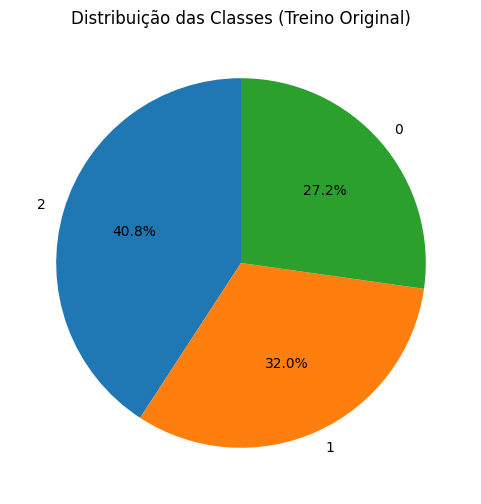

In [463]:
plt.figure(figsize=(6,6))
plt.pie(y_train.value_counts(), labels=y_train.value_counts().index, autopct='%1.1f%%', startangle=90)
plt.title("Distribuição das Classes (Treino Original)")
plt.show()

#### XGBoost

In [464]:
class_weights = {0: 1, 1: 1, 2: 1}

c:\Users\rodrigo\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning:

[01:34:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.




=== Relatório de Classificação ===
              precision    recall  f1-score   support

           0       0.22      0.02      0.03      1566
           1       0.43      0.68      0.53      3278
           2       0.62      0.56      0.59      4684

    accuracy                           0.51      9528
   macro avg       0.43      0.42      0.38      9528
weighted avg       0.49      0.51      0.48      9528



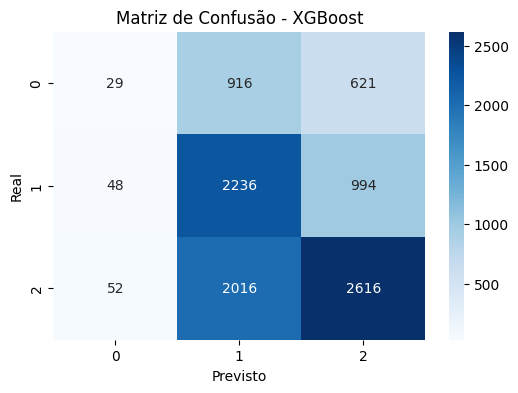

In [465]:
# === 4. Pesos das classes ===
classes = np.unique(y_train)

# Exemplo de pesos (ajuste conforme necessidade)

sample_weights = np.array([class_weights[y] for y in y_train])

# === 5. Modelo XGBoost ===
model = xgb.XGBClassifier(
    objective="multi:softmax",
    num_class=3,
    eval_metric="mlogloss",
    use_label_encoder=False,
    n_estimators=300,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

# Treinar modelo
model.fit(X_train, y_train, sample_weight=sample_weights)

# Previsões
df_test['pred'] = model.predict(X_test)

# === 6. Avaliação ===
print("=== Relatório de Classificação ===")
print(classification_report(df_test['target'], df_test['pred']))

cm = confusion_matrix(df_test['target'], df_test['pred'])

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=[0,1,2], yticklabels=[0,1,2])
plt.xlabel("Previsto")
plt.ylabel("Real")
plt.title("Matriz de Confusão - XGBoost")
plt.show()

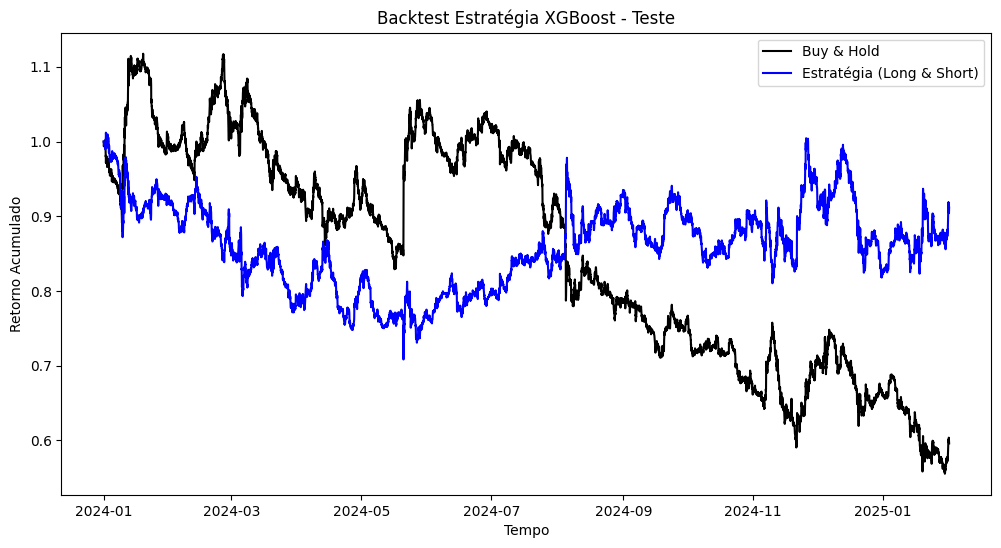

Retorno total da estratégia: -8.84%
Sharpe ratio aproximado: -0.01
Taxa de acerto (dias positivos): 46.47%


In [466]:
import matplotlib.pyplot as plt
import numpy as np

# Garantir que preços estão ordenados por tempo
df_test = df_test.sort_values('time').reset_index(drop=True)

# Calcular retornos do ativo
df_test['returns'] = df_test['close'].pct_change()

# Definir posição da estratégia
df_test['position'] = 0
df_test.loc[df_test['pred'] == 1, 'position'] = 1   # Long
df_test.loc[df_test['pred'] == 2, 'position'] = -1  # Short

# Evitar lookahead bias (shift para só operar no próximo dia)
df_test['position'] = df_test['position'].shift(1).fillna(0)

# Retorno da estratégia
df_test['strategy_return'] = df_test['position'] * df_test['returns']

# Retornos acumulados
df_test['cum_asset'] = (1 + df_test['returns']).cumprod()
df_test['cum_strategy'] = (1 + df_test['strategy_return']).cumprod()

# === Plot Backtest ===
plt.figure(figsize=(12,6))
plt.plot(df_test['time'], df_test['cum_asset'], label='Buy & Hold', color='black')
plt.plot(df_test['time'], df_test['cum_strategy'], label='Estratégia (Long & Short)', color='blue')
plt.title("Backtest Estratégia XGBoost - Teste")
plt.xlabel("Tempo")
plt.ylabel("Retorno Acumulado")
plt.legend()
plt.show()

# === Métricas ===
total_return = df_test['cum_strategy'].iloc[-1] - 1
sharpe_ratio = df_test['strategy_return'].mean() / df_test['strategy_return'].std() * np.sqrt(252)
hit_ratio = (df_test['strategy_return'] > 0).mean()

print(f"Retorno total da estratégia: {total_return:.2%}")
print(f"Sharpe ratio aproximado: {sharpe_ratio:.2f}")
print(f"Taxa de acerto (dias positivos): {hit_ratio:.2%}")


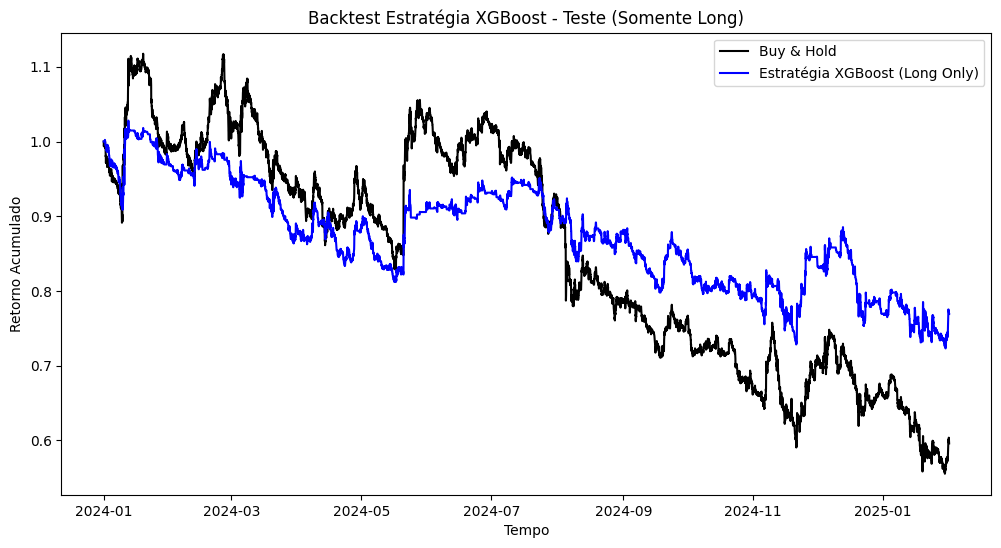

Retorno total da estratégia: -23.09%
Sharpe ratio aproximado: -0.12
Taxa de acerto (dias positivos): 24.15%


In [467]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Garantir ordenação temporal
df_test = df_test.sort_values('time').reset_index(drop=True)

# Calcular retorno diário do ativo
df_test['returns'] = df_test['close'].pct_change()

# Definir posição da estratégia (Long Only: pred == 1)
df_test['position'] = 0
df_test.loc[df_test['pred'] == 1, 'position'] = 1   # Long
# Evitar lookahead bias
df_test['position'] = df_test['position'].shift(1).fillna(0)

# Retorno da estratégia
df_test['strategy_return'] = df_test['position'] * df_test['returns']

# Retornos acumulados
df_test['cum_asset'] = (1 + df_test['returns']).cumprod()
df_test['cum_strategy'] = (1 + df_test['strategy_return']).cumprod()

# Plot do backtest
plt.figure(figsize=(12,6))
plt.plot(df_test['time'], df_test['cum_asset'], label='Buy & Hold', color='black')
plt.plot(df_test['time'], df_test['cum_strategy'], label='Estratégia XGBoost (Long Only)', color='blue')
plt.title("Backtest Estratégia XGBoost - Teste (Somente Long)")
plt.xlabel("Tempo")
plt.ylabel("Retorno Acumulado")
plt.legend()
plt.show()

# Métricas de performance
total_return = df_test['cum_strategy'].iloc[-1] - 1
sharpe_ratio = df_test['strategy_return'].mean() / df_test['strategy_return'].std() * np.sqrt(252)
hit_ratio = (df_test['strategy_return'] > 0).mean()

print(f"Retorno total da estratégia: {total_return:.2%}")
print(f"Sharpe ratio aproximado: {sharpe_ratio:.2f}")
print(f"Taxa de acerto (dias positivos): {hit_ratio:.2%}")


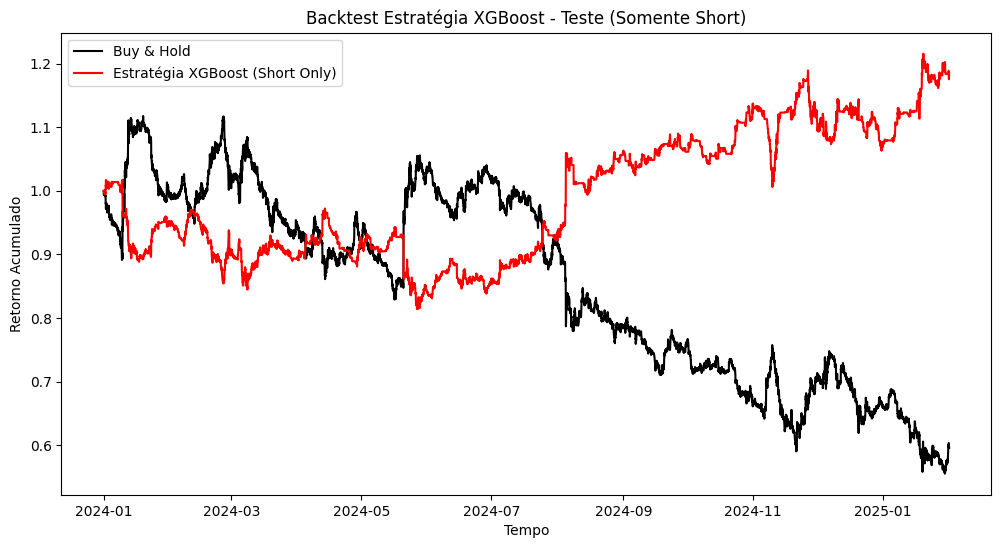

Retorno total da estratégia: 18.53%
Sharpe ratio aproximado: 0.13
Taxa de acerto (dias positivos): 22.32%


In [468]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Garantir ordenação temporal
df_test = df_test.sort_values('time').reset_index(drop=True)

# Calcular retorno diário do ativo
df_test['returns'] = df_test['close'].pct_change()

# Definir posição da estratégia (Short Only: pred == 2)
df_test['position'] = 0
df_test.loc[df_test['pred'] == 2, 'position'] = -1   # Short
# Evitar lookahead bias
df_test['position'] = df_test['position'].shift(1).fillna(0)

# Retorno da estratégia
df_test['strategy_return'] = df_test['position'] * df_test['returns']

# Retornos acumulados
df_test['cum_asset'] = (1 + df_test['returns']).cumprod()
df_test['cum_strategy'] = (1 + df_test['strategy_return']).cumprod()

# Plot do backtest
plt.figure(figsize=(12,6))
plt.plot(df_test['time'], df_test['cum_asset'], label='Buy & Hold', color='black')
plt.plot(df_test['time'], df_test['cum_strategy'], label='Estratégia XGBoost (Short Only)', color='red')
plt.title("Backtest Estratégia XGBoost - Teste (Somente Short)")
plt.xlabel("Tempo")
plt.ylabel("Retorno Acumulado")
plt.legend()
plt.show()

# Métricas de performance
total_return = df_test['cum_strategy'].iloc[-1] - 1
sharpe_ratio = df_test['strategy_return'].mean() / df_test['strategy_return'].std() * np.sqrt(252)
hit_ratio = (df_test['strategy_return'] > 0).mean()

print(f"Retorno total da estratégia: {total_return:.2%}")
print(f"Sharpe ratio aproximado: {sharpe_ratio:.2f}")
print(f"Taxa de acerto (dias positivos): {hit_ratio:.2%}")


In [469]:
class_weights = {0: 1, 1: 1, 2: 1}

c:\Users\rodrigo\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning:

[01:34:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "scale_pos_weight", "use_label_encoder" } are not used.




=== Relatório de Classificação ===
              precision    recall  f1-score   support

           0       0.32      0.02      0.04      1566
           1       0.44      0.70      0.54      3278
           2       0.62      0.56      0.59      4684

    accuracy                           0.52      9528
   macro avg       0.46      0.43      0.39      9528
weighted avg       0.51      0.52      0.48      9528



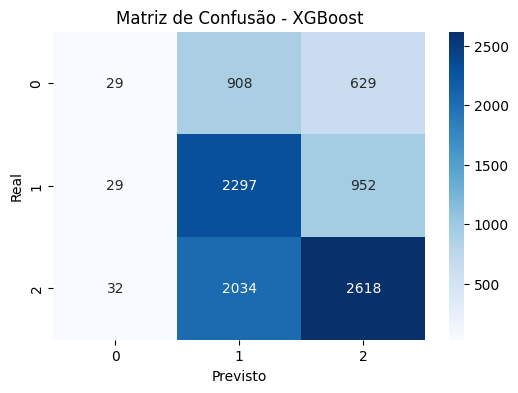

In [470]:
import xgboost as xgb
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Classes únicas
classes = np.unique(y_train)

# Pesos manuais
sample_weights = np.array([class_weights[y] for y in y_train])

# Criar modelo XGBoost com hiperparâmetros adicionais
model = xgb.XGBClassifier(
    objective="multi:softmax",
    num_class=3,
    eval_metric="mlogloss",
    use_label_encoder=False,
    n_estimators=200,
    learning_rate=0.05,
    max_depth=6,
    min_child_weight=10,
    gamma=0,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=1,
    reg_alpha=0.1,
    reg_lambda=0.01,
    random_state=42
)

# Treinar modelo
model.fit(X_train, y_train, sample_weight=sample_weights)

# Prever no teste
y_pred = model.predict(X_test)

# Adicionar previsões no df_test
df_test['pred'] = y_pred

# === Avaliação ===
print("=== Relatório de Classificação ===")
print(classification_report(y_test, y_pred))

# Matriz de confusão
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=[0,1,2], yticklabels=[0,1,2])
plt.xlabel("Previsto")
plt.ylabel("Real")
plt.title("Matriz de Confusão - XGBoost")
plt.show()


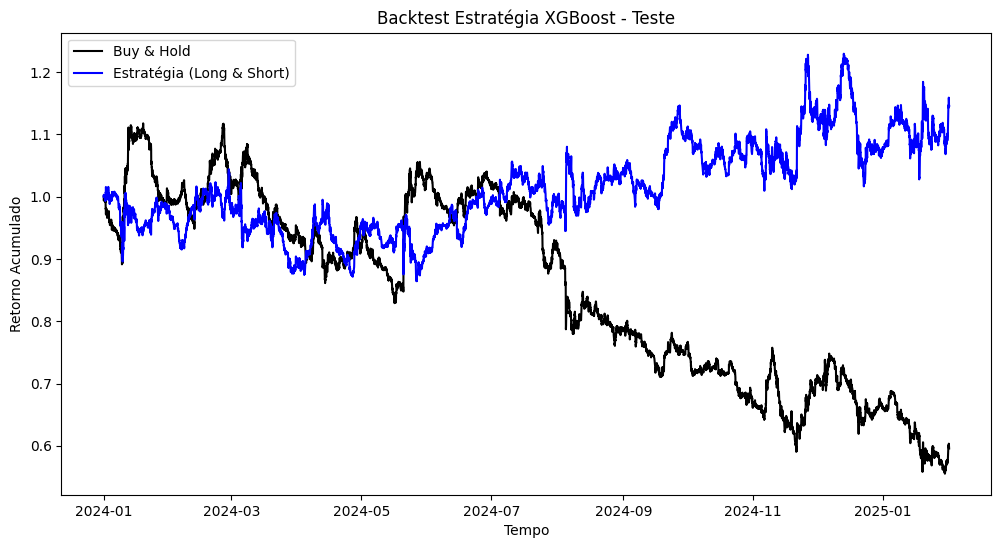

Retorno total da estratégia: 14.49%
Sharpe ratio aproximado: 0.09
Taxa de acerto: 46.71%


In [471]:
import matplotlib.pyplot as plt
import numpy as np

# Garantir que preços estão ordenados por tempo
df_test = df_test.sort_values('time').reset_index(drop=True)

# Calcular retornos do ativo
df_test['returns'] = df_test['close'].pct_change()

# Definir posição da estratégia
df_test['position'] = 0
df_test.loc[df_test['pred'] == 1, 'position'] = 1   # Long
df_test.loc[df_test['pred'] == 2, 'position'] = -1  # Short

# Evitar lookahead bias (shift para só operar no próximo dia)
df_test['position'] = df_test['position'].shift(1).fillna(0)

# Retorno da estratégia
df_test['strategy_return'] = df_test['position'] * df_test['returns']

# Retornos acumulados
df_test['cum_asset'] = (1 + df_test['returns']).cumprod()
df_test['cum_strategy'] = (1 + df_test['strategy_return']).cumprod()

# === Plot Backtest ===
plt.figure(figsize=(12,6))
plt.plot(df_test['time'], df_test['cum_asset'], label='Buy & Hold', color='black')
plt.plot(df_test['time'], df_test['cum_strategy'], label='Estratégia (Long & Short)', color='blue')
plt.title("Backtest Estratégia XGBoost - Teste")
plt.xlabel("Tempo")
plt.ylabel("Retorno Acumulado")
plt.legend()
plt.show()

# === Métricas ===
total_return = df_test['cum_strategy'].iloc[-1] - 1
sharpe_ratio = df_test['strategy_return'].mean() / df_test['strategy_return'].std() * np.sqrt(252)
hit_ratio = (df_test['strategy_return'] > 0).mean()

print(f"Retorno total da estratégia: {total_return:.2%}")
print(f"Sharpe ratio aproximado: {sharpe_ratio:.2f}")
print(f"Taxa de acerto: {hit_ratio:.2%}")


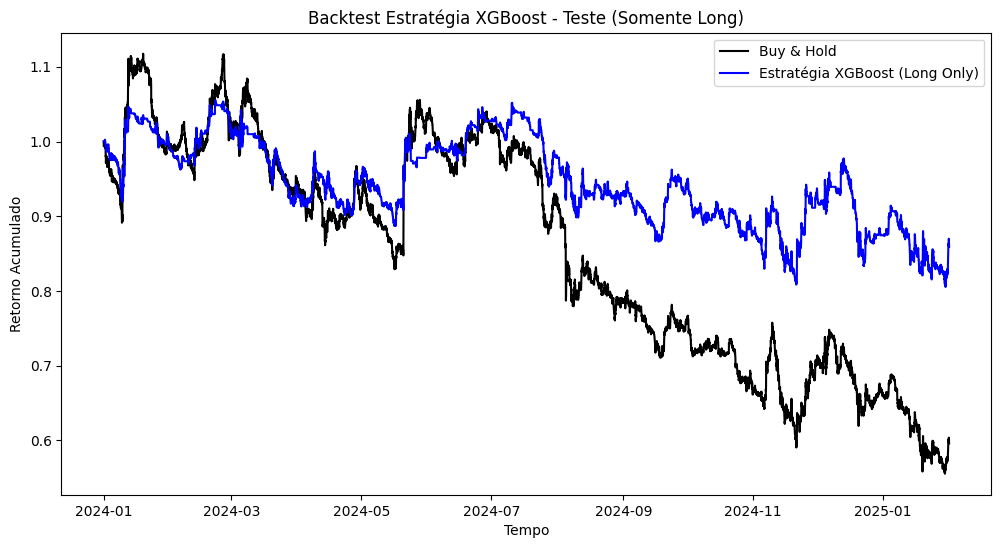

Retorno total da estratégia: -14.08%
Sharpe ratio aproximado: -0.06
Taxa de acerto: 24.55%


In [472]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Garantir ordenação temporal
df_test = df_test.sort_values('time').reset_index(drop=True)

# Calcular retorno diário do ativo
df_test['returns'] = df_test['close'].pct_change()

# Definir posição da estratégia (Long Only: pred == 1)
df_test['position'] = 0
df_test.loc[df_test['pred'] == 1, 'position'] = 1   # Long
# Evitar lookahead bias
df_test['position'] = df_test['position'].shift(1).fillna(0)

# Retorno da estratégia
df_test['strategy_return'] = df_test['position'] * df_test['returns']

# Retornos acumulados
df_test['cum_asset'] = (1 + df_test['returns']).cumprod()
df_test['cum_strategy'] = (1 + df_test['strategy_return']).cumprod()

# Plot do backtest
plt.figure(figsize=(12,6))
plt.plot(df_test['time'], df_test['cum_asset'], label='Buy & Hold', color='black')
plt.plot(df_test['time'], df_test['cum_strategy'], label='Estratégia XGBoost (Long Only)', color='blue')
plt.title("Backtest Estratégia XGBoost - Teste (Somente Long)")
plt.xlabel("Tempo")
plt.ylabel("Retorno Acumulado")
plt.legend()
plt.show()

# Métricas de performance
total_return = df_test['cum_strategy'].iloc[-1] - 1
sharpe_ratio = df_test['strategy_return'].mean() / df_test['strategy_return'].std() * np.sqrt(252)
hit_ratio = (df_test['strategy_return'] > 0).mean()

print(f"Retorno total da estratégia: {total_return:.2%}")
print(f"Sharpe ratio aproximado: {sharpe_ratio:.2f}")
print(f"Taxa de acerto: {hit_ratio:.2%}")


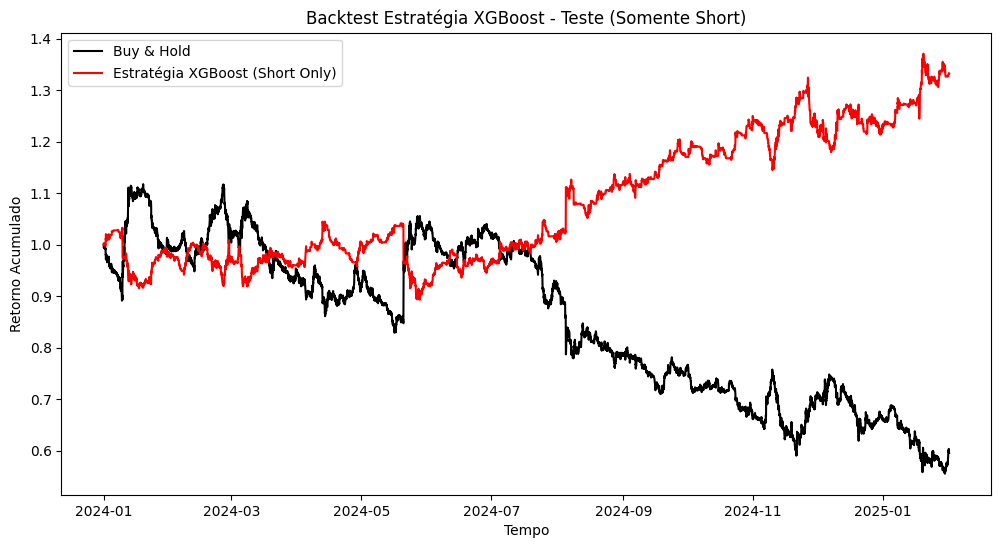

Retorno total da estratégia: 33.26%
Sharpe ratio aproximado: 0.20
Taxa de acerto: 22.17%


In [473]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Garantir ordenação temporal
df_test = df_test.sort_values('time').reset_index(drop=True)

# Calcular retorno diário do ativo
df_test['returns'] = df_test['close'].pct_change()

# Definir posição da estratégia (Short Only: pred == 2)
df_test['position'] = 0
df_test.loc[df_test['pred'] == 2, 'position'] = -1   # Short
# Evitar lookahead bias
df_test['position'] = df_test['position'].shift(1).fillna(0)

# Retorno da estratégia
df_test['strategy_return'] = df_test['position'] * df_test['returns']

# Retornos acumulados
df_test['cum_asset'] = (1 + df_test['returns']).cumprod()
df_test['cum_strategy'] = (1 + df_test['strategy_return']).cumprod()

# Plot do backtest
plt.figure(figsize=(12,6))
plt.plot(df_test['time'], df_test['cum_asset'], label='Buy & Hold', color='black')
plt.plot(df_test['time'], df_test['cum_strategy'], label='Estratégia XGBoost (Short Only)', color='red')
plt.title("Backtest Estratégia XGBoost - Teste (Somente Short)")
plt.xlabel("Tempo")
plt.ylabel("Retorno Acumulado")
plt.legend()
plt.show()

# Métricas de performance
total_return = df_test['cum_strategy'].iloc[-1] - 1
sharpe_ratio = df_test['strategy_return'].mean() / df_test['strategy_return'].std() * np.sqrt(252)
hit_ratio = (df_test['strategy_return'] > 0).mean()

print(f"Retorno total da estratégia: {total_return:.2%}")
print(f"Sharpe ratio aproximado: {sharpe_ratio:.2f}")
print(f"Taxa de acerto: {hit_ratio:.2%}")


In [474]:
df.hurst_150.min()

0.2879226746825548

In [475]:
hurst_value = 0

In [476]:
df.columns

Index(['time', 'open', 'high', 'low', 'close', 'volume', 'quote_volume',
       'count', 'taker_buy_volume', 'taker_buy_quote_volume', 'target',
       'return', 'AvgVolume', 'AVAT', 'Log_Returns', 'reference_price_w',
       'weekly_vol_garch', 'upper_garch_1w_2d', 'lower_garch_1w_2d',
       'upper_garch_1w_4d', 'lower_garch_1w_4d', 'upper_garch_1w_6d',
       'lower_garch_1w_6d', 'garch_mid_w', 'distance_w', 'distance_w_17_mean',
       'distance_w_72_mean', 'hurst_100', 'hurst_150', 'sma20', 'sma20_1diff',
       'sma20_1diff_1shift', 'sma20_diff_product', 'indicator_increasing',
       'indicator_decreasing', 'indicator_trend_pos_to_neg',
       'indicator_trend_neg_to_pos', 'increasing_days', 'decreasing_days',
       'zero_cross_neg', 'zero_cross_pos', 'zero_cross_total', 'ratio_trend',
       'ratio_zero', 'ratio_trend_normalized', 'ratio_zero_normalized',
       'product_ratio'],
      dtype='object')

In [477]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import numpy as np

df.set_index('time', inplace=True)

# Criar subplot com 2 linhas (preço + hurst)
fig = make_subplots(
    rows=2, cols=1,
    shared_xaxes=True,
    row_heights=[0.7, 0.3],  # 70% para preço, 30% para hurst
    vertical_spacing=0.05
)



fig.add_trace(go.Scatter(
    x=df.index,
    y=df['close'],
    mode='lines',
    line=dict(color=color),
    showlegend=False
), row=1, col=1)

# Adicionar Hurst na segunda linha
fig.add_trace(go.Scatter(
    x=df.index,
    y=df['hurst_400'],
    mode='lines',
    line=dict(color='blue'),
    name='Hurst 150'
), row=2, col=1)

# Layout
fig.update_layout(
    title="WINFUT Close Price + Hurst 150",
    xaxis_title="Tempo",
    yaxis_title="Preço",
    xaxis2_title="Tempo",
    yaxis2_title="Hurst 150",
    template="plotly_white",
    hovermode="x unified",
    height=600
)

fig.show()
df.reset_index(inplace=True)


KeyError: 'hurst_400'